### 1. 定义一个简单的多臂老虎机

我们定义期望奖励 $Q_k = \frac{1}{k} \sum \limits_{i = 1}^{k} r_i$，但是我们发现该公式在计算时每次都需要从 1 开始迭代计算，这使得其时间复杂度为 O(n),我们可以定义增量计算方法。
$
Q_k = \frac{1}{k} \sum \limits_{i = 1}^{k} r_i \\
     = \frac{1}{k}(r_k + \sum\limits_{i = 1}^{k - 1}r_i) \\
$
$\because$  $Q_{k-1} = \frac{1}{k-1} \sum \limits_{i = 1}^{k - 1}r_i$ $\\$
$\therefore$
$ Q_k = \frac{1}{k}(r_k + \sum \limits_{i = 1}^{k - 1}r_i) \\
      = \frac{1}{k}(r_k + (k - 1)Q_{k-1})\\
      = \frac{1}{k}(r_k + kQ_{k-1} - Q_{k-1})\\
      = Q_{k-1} + \frac{1}{k}(r_k - Q_{k-1})\\
$

通过上述变换，我们将累计期望奖励写成增量形式，这使得编程更为方便，且时空复杂度从 O(n) 变为 O(1).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

下面分别比较了 np.random.uniform(k) 和 np.random.uniform(size=k) 两个函数的差别，前一个函数生成一个小于 10 的随机数，后一个函数生成 10 个 0 ~ 1 之间的随机数

In [6]:
np.random.uniform(10)

5.851686695329755

In [7]:
array = np.random.uniform(size=10)
print(array)
np.argmax(array)

[0.43313113 0.57179357 0.25863821 0.06302875 0.68861221 0.07820576
 0.0096127  0.46967561 0.81237568 0.44691416]


8

In [8]:
print(np.random.rand())

0.9475782676486538


定义一个多臂老虎机类，并且拉动每个杆的奖励服从**伯努利分布**， 即每次拉动拉杆都有 p 的概率获得奖励，有 1-p 的概率没有获得奖励.

In [9]:
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K
    # step 表示随机拉动用整数 k 表示的拉杆
    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
np.random.seed(1)
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个 %d 臂老虎机" % K)
print("获奖概率最大的拉杆为 %d 号，其获奖概率为 %.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个 10 臂老虎机
获奖概率最大的拉杆为 1 号，其获奖概率为 0.7203


In [10]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K) # 每根拉杆的尝试次数
        self.regret = 0
        self.actions = []
        self.regrets = []
    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
    def run_one_step(self):
        raise NotImplementedError
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)      

在上述算法框架中，并没有给出 run_one_step 时的策略，即拉动哪根拉杆，所以接下来应该学习如何设计一个策略，例如，一个最简单的策略就是一直采取第一个动作，但这就非常依赖运气的好坏。如果运气绝佳，可能拉动的刚好就是能获得最大期望奖励的拉杆，即最优拉杆；但如果运气很糟糕，获得的就有可能是最小的期望奖励。在多臂老虎机问题中，一个经典的问题就是探索与利用的平衡问题。探索 (exploration)是指尝试拉动更多可能的拉杆，这根拉杆不一定会获得最大的奖励，但这种方法能够摸清楚所有拉杆的获奖情况 (显然在我们的多臂老虎机中假设每次拉动同一根杆的概率恒定不变)。例如，对于一个 10 臂老虎机，我们要把所有的拉杆都拉动一下才知道哪根拉杆可能获得最大的奖励。利用 (exploitation)是指拉动已知期望奖励最大的拉杆，由于已知的信息仅仅来自于有限次的交互观测，所以当前的最优拉杆不一定是全局最优的。例如对于一个 10 臂老虎机，我们只拉动其中的 3 根拉杆，接下来就一直拉动这 3 根拉杆中期望奖励最大的那根拉杆，但很有可能期望奖励最大的拉杆在剩下的 7 根拉杆中，即使我们对 10 根拉杆各自都尝试了 20 次，但是仍然存在着微小的概率另一根 6 号拉杆的真实期望奖励是比 5 号拉杆更高的。

于是在多臂老虎机问题中，设计策略时就需要平衡探索和利用的次数，使得累计奖励最大化。一个比较常用的思路是在开始时做比较多的探索，在对每根拉杆都有比较准确的估计后，再进行利用。目前已经有一些比较经典的算法来解决这个问题，例如**贪婪算法**、**softmax**、**上置信界算法**和**汤普森采用算法**等，我们接下来将分别使用这几种算法作为 run_one_step 的策略。

### 2. 探讨多臂老虎机拉杆策略 (Actions)

#### 2.1 贪心策略

完全贪心算法 (greedy) 即在每一个时刻都采取期望奖励估计最大的动作，这就是纯粹的利用，没有探索，所以我们通常需要对完全贪心算法进行一些修改，其中比较经典的一种方法为 epsilon-greedy 算法。该算法在完全贪心的基础上添加了噪声，每次以 1 - epsilon 的选择以往经验中期望奖励估计最大的拉杆 (利用),以概率 epsilon 随机选择一根拉杆 (探索)。

随着探索的不断增加，我们对各个动作的奖励估计得越来越准确，此时就没有必要进行探索。所以在该算法实现中，我们令 epsilon 随时间衰减，即探索的概率将会不断降低。但是需要注意的是，epsilon 不会在有限的步骤内衰减为 0，因为基于有限步数观测的完全贪心算法仍然是一个局部信息的贪心算法。永远距离最优解有一个固定的差距。

In [11]:
np.random.random() # 生成一个 0 ~ 1 之间的数字

0.4191945144032948

In [12]:
class Greedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(Greedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
    def run_one_step(self):
        k = np.argmax(self.estimates)  # 完全放弃了探索，每次都是选取上一次最大的
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [13]:
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

贪婪算法的累积懊悔为： 910.1227689824777


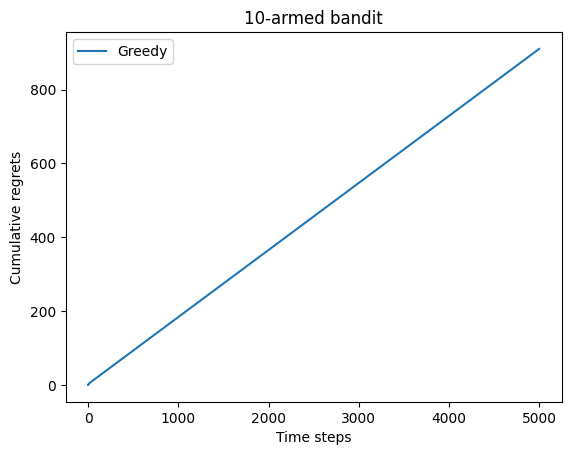

In [14]:
# Greedy
greedy_solver = Greedy(bandit_10_arm)
greedy_solver.run(5000)
print('贪婪算法的累积懊悔为：', greedy_solver.regret)
plot_results([greedy_solver], ["Greedy"])

#### 2.4 softmax 策略算法

考虑一个双臂老虎机问题，有下面两种情况：
(1)第一根拉杆的平均奖励为 0.1,第二根拉杆的平均奖励为 0.9;
(2)第一根拉杆的平均奖励为 0.1,第二跟拉杆的平均奖励为 0.11。

如果采用 epsilon-greedy 算法，它不会考虑过去的奖励，而是随机在两根拉杆中选择，但是 softmax 算法会考虑过往的奖励。

In [15]:
# Arm selection based on Softmax probability
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        
        if cum_prob > z:
            return i
    return len(probs) - 1

class Softmax(Solver):
    def __init__(self, tau, bandit, init_prob=1.0):
        super(Softmax, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.tau = tau
    def run_one_step(self):
        # Calculate Softmax probabilities based on each round
        z = sum([math.exp(v / self.tau) for v in self.estimates])
        probs = [math.exp(v / self.tau) / z for v in self.estimates]
        k = categorical_draw(probs) # Use categorical_draw to pick arm
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

softmax 算法的累积懊悔为： 7.937867540542887


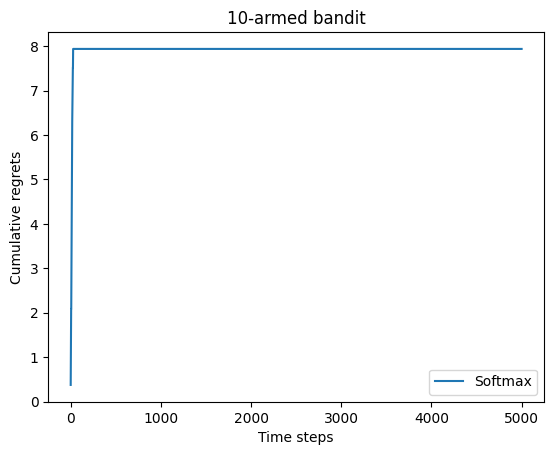

In [16]:
softmax_solver = Softmax(0.01, bandit_10_arm)
softmax_solver.run(5000)
print('softmax 算法的累积懊悔为：', softmax_solver.regret)
plot_results([softmax_solver], ["Softmax"])

softmax 算法不稳定，累计后悔有时候线性增长，有时候对数增长，对 tau 值很敏感。

In [17]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值,[init_prob] * 10，相当于 [1.0, 1.0, ...] 10个
        self.estimates = np.array([init_prob] * self.bandit.K)
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K) # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1.0 / (self.counts[k]+1) * (r - self.estimates[k])
        return k

为了更加直观地展示，可以把每一时间步的累计函数绘制出来。于是我们定义了以下绘图函数，方便之后调用。

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


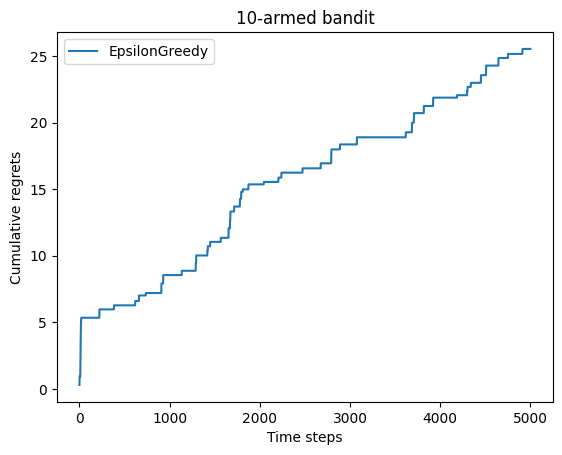

In [18]:
# EpsilonGreedy
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

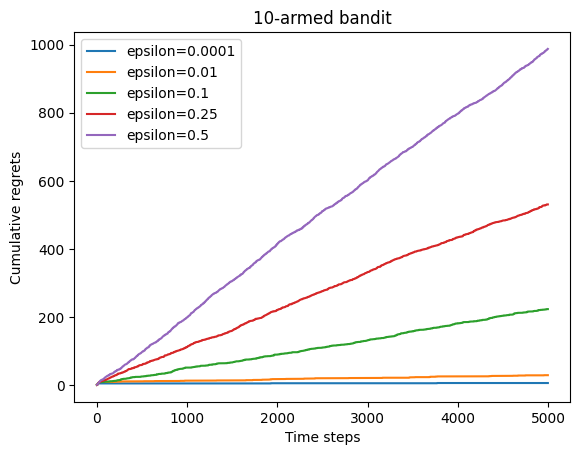

In [19]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

**结论：** 我们看到无论 epsilon 取何值，累计懊悔都是线性增长的。在这个例子中，随着 epsilon 的增大，累计懊悔增长的速率也变会增大。接下来我们来看带有衰减的 epsilon 贪心算法。

epsilon值衰减的贪婪算法的累积懊悔为： 10.656380311234374


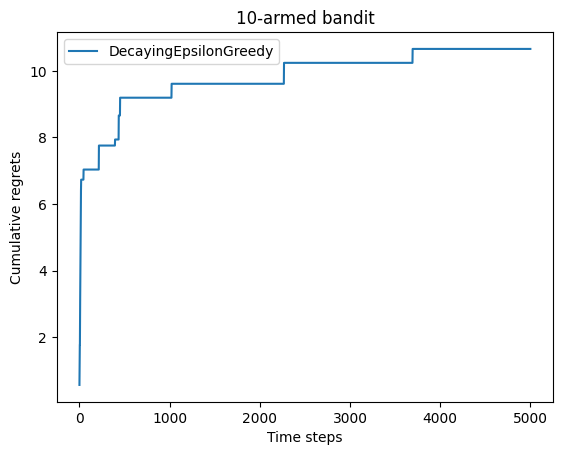

In [20]:
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / (self.total_count + 0.00001):  # epsilon值count总数衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

#### 2.2 上置信界算法

设想这样一种情况：对于一台双臂老虎机，其中第一根拉杆只被拉动过一次，得到的奖励为 0， 第二跟拉杆被拉动过很多次，我们对它的奖励分布已经有了大致的把我。接下来你会怎么做呢？或许你会尝试拉动第一根拉杆，从而确定其奖励分布。这种思路主要是基于不确定性，因此此时第一根拉杆只被拉动过一次，它的不确定性非常高。一根拉杆的不确定性越大，它就越具有探索价值，因此探索之后我们可能发现它的期望奖励很大。我们再次引入不确定性度量 $U(a)$，它会随着一个动作被尝试次数的增加而减小。我们可以使用一种基于不确定性的策略来综合考虑现有的期望奖励估值和不确定性，其核心问题是如何估计不确定性。

上置信界算法是一种经典的基于不确定性的策略算法，它的思想用到了非常著名的数学原理：hoeffding's inequality.

上置信界算法的累积懊悔为： 60.018852393536285


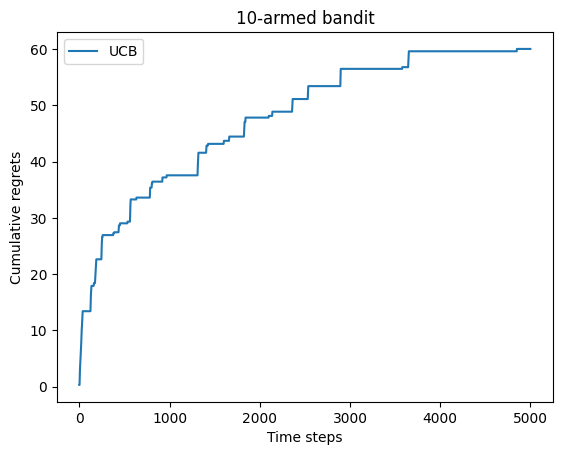

In [21]:
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
   
coef = 1
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

#### 2.3 汤普森采样算法

多臂老虎机还有一个经典的算法- Thompson sampling，先假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来选择。但是由于计算所有拉杆的期望奖励代价比较高， Thompson Sampling 方法使用采用的方式，即根据当前每个动作 a 的奖励概率分布进行一轮采样，得到一组各根拉杆的奖励样本，再选择样本中奖励最大的动作。可以看出，Thompson Sampling 是一种计算所有拉杆最高奖励概率的蒙特卡洛采样方法。

了解了汤普森采用算法的基本思路后，我哦们需要解决的另外一个问题：怎样得到当前每个动作 a 的奖励概率分布并且在过程中更新呢？在实际情况中，我们通常用 beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若拉杆被选择了 k 次，其中 $m_1$ 次奖励为 1， $m_2$ 次奖励为 0，则该拉杆的奖励服从参数为 ($m_1$ + 1, $m_2$ + 1) 的 beta 分布。

汤普森采样算法的累积懊悔为： 59.226656647101734


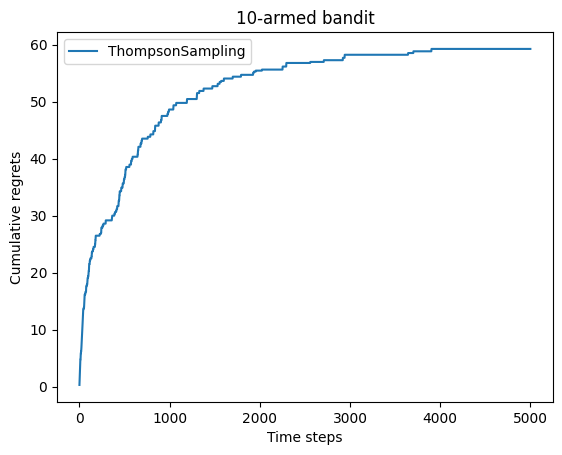

In [22]:
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)
    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += (1-r)
        return k
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

**总结: 通过实验我们可以得到:
(1)epsilon-greedy 方法的累计后悔随着时间线性增常;
(2)带有衰减的 epsilon-greedy、上置信界算法、汤普森采样算法累计懊悔都是对数形式增长的;
(3)softmax 算法表现不稳定。**

### 3 总结
探索与利用是与环境交互学习的重要问题，是强化学习试错法中的必备技术，而多臂老虎机问题是研究探索与利用技术理论的最佳环境。了解多臂老虎机的探索与利用问题，对接下来学习强化学习探索有很重要的帮助。对于多臂老虎机各种算法累计懊悔的理论分析，可以查阅更多的资料。这三种算法在多臂老虎机问题中十分常用，其中上置信界算法和汤普森算法均能保证对数的渐进最优累计懊悔。

多臂老虎机问题与强化学习的一大区别在于其与环境交互并不会改变环境，即多臂老虎机的每次交互结果与以往动的动作无关，所以可看作无状态的强化学习(stateless reinforcement learning)。